In [1]:
# Generate 10,000 samples to simulate a stationary AR(4) process

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
my_sample_size = 1000
my_test_size = 50
my_axvspan1 = 950
my_axvspan2 = my_sample_size
my_set_xlim = 920

if my_sample_size == 10000:
    my_test_size = 500
    my_axvspan1 = 9500
    my_set_xlim = 9300

In [4]:
np.random.seed(100)

#yt = 0.08yt–1 - 0.25yt–2 + 0.38yt–3 - 0.58yt-4
ma4 = np.array([1, 0, 0, 0, 0])
ar4 = np.array([1, -0.08, 0.25, -0.38, 0.58])

AR4_process = ArmaProcess(ar4, ma4).generate_sample(nsample = my_sample_size)

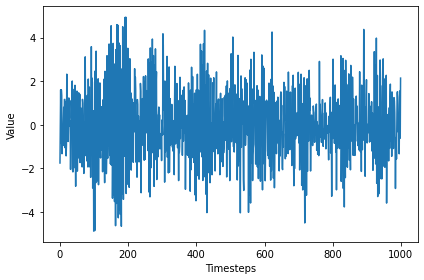

In [5]:
fig, ax = plt.subplots()

ax.plot(AR4_process)
ax.set_xlabel("Timesteps")
ax.set_ylabel("Value")

plt.tight_layout()

In [6]:
# Run the ADF test and check if the process is stationary
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(AR4_process)

print(f"ADF Statistic: {ADF_result[0]}")
print(f"P-Value: {ADF_result[1]}")

ADF Statistic: -15.956123237460309
P-Value: 7.265022776293707e-29


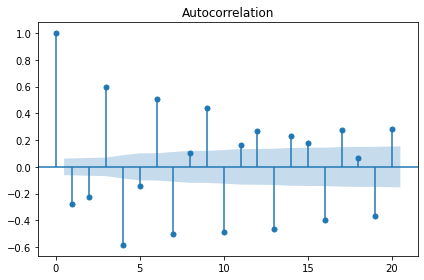

In [7]:
# The process is already stationery with a p-value less than 0.05 and a large negative value(no differenciation required)
# Plot the ACF to see if it is slowly decaying

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(AR4_process, lags=20)
plt.tight_layout()

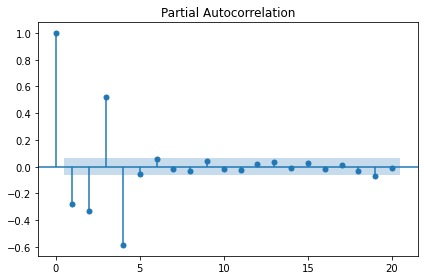

In [8]:
# Since it is slowly decaying (both sides because the coefficients have both signs), we do not have moving average process
# Plot the PACF to see if there are significant coefficients after 4 lags
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR4_process, lags=20)
plt.tight_layout()

In [9]:
# There is a suddden drop in significant coefficients after lag 4, so it is confirmed that we have a AR(4) process,
# Separate your simulated series into train and test sets. Take the first 9500 timesteps for the train set 
# and assign the rest to the test set.

df = pd.DataFrame({'Value': AR4_process})

train = df[:-my_test_size].copy()
test = df[-my_test_size:].copy()

print(len(train))
print(len(test))

950
50


In [10]:
# Make forecasts over the test set. Use the historical mean method, last known value method, and an AR(4) model. 
# Use the rolling_forecast function, and use a window length of 2.

from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(4,0,0))      #The order specifies the AR(4) model
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)

        return pred_AR

In [11]:
#We wish to predict the next for three different window sizes i.e 1,2,3
TRAIN_LEN = len(train)
HORIZON = len(test)

method_List = ["mean", "last", "AR"]

for i in range(1,4):
    #wind_List = f"wind{i}_List" 
    
    for method in method_List:
        mean_attr = f"pred_{method}{i}"
                
        current_forecast = rolling_forecast(df, TRAIN_LEN, HORIZON, i, method)
        
        # The rolling forecast generated 501 predictions, but we need only the first
        # 500 predictions to match the length of the test set
        test.loc[:, mean_attr] = current_forecast[:my_test_size]


test.head()

,Value,pred_mean1,pred_last1,pred_AR1,pred_mean2,pred_last2,pred_AR2,pred_mean3,pred_last3,pred_AR3
950,-1.893469,-0.012055,-0.513941,-1.752198,-0.012055,-0.513941,-1.752198,-0.012055,-0.513941,-1.752198
951,1.592061,-0.014033,-1.893469,1.114723,-0.012055,-0.513941,1.128973,-0.012055,-0.513941,1.128973
952,-0.646300,-0.012346,1.592061,-1.398026,-0.012346,1.592061,-1.398026,-0.012055,-0.513941,-1.474752
953,-1.942887,-0.013011,-0.646300,-0.874115,-0.012346,1.592061,-0.946756,-0.013011,-0.646300,-0.874115
954,2.123098,-0.015034,-1.942887,1.693246,-0.015034,-1.942887,1.693246,-0.013011,-0.646300,1.796946


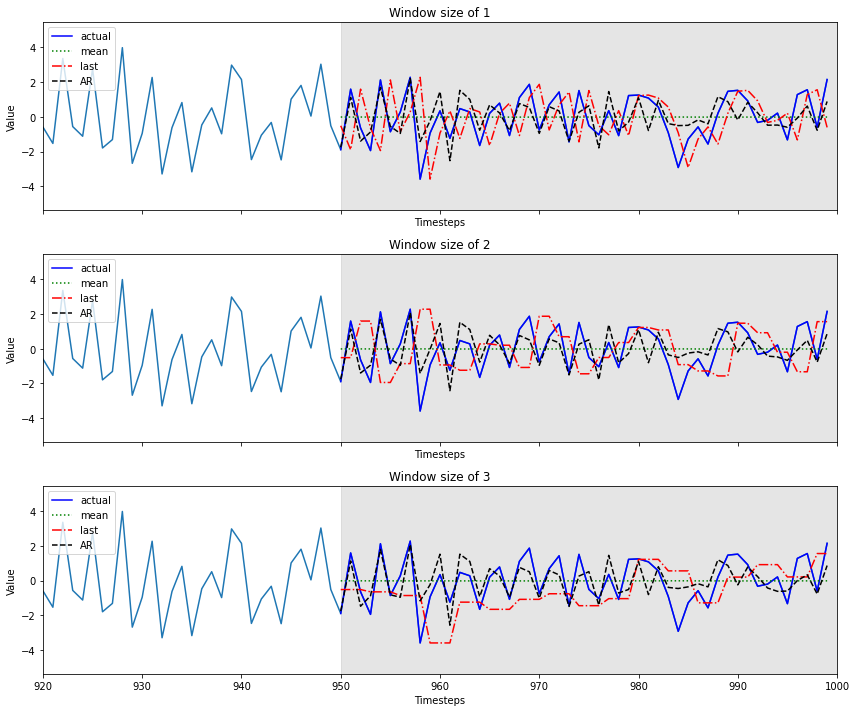

In [12]:
line_color = ['g:','r-.','k--']

#fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 10))

for i, ax in zip(range(1,4), axes):
    my_ax = f"ax{i}"
    
    ax.plot(df['Value'])
    ax.plot(test['Value'], 'b-', label='actual')
    
    for method, clr in zip(method_List, line_color):
        mean_attr = f"pred_{method}{i}"
        ax.plot(test[mean_attr], clr, label=method)

    ax.legend(loc=2)

    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Value')
    ax.set_title(f"Window size of {i}")
    ax.axvspan(my_axvspan1, my_axvspan2, color='#808080', alpha=0.2)

    ax.set_xlim(my_set_xlim, my_axvspan2)


plt.tight_layout()

In [13]:
# Measure the MSE, and identify your champion model
from sklearn.metrics import mean_squared_error

wind1Perf_List = []
wind2Perf_List = []
wind3Perf_List = []
windPerf_List = [wind1Perf_List, wind2Perf_List, wind3Perf_List]

for i in range(1,4):
    #windPerf_List = f"wind{i}perf_List" 
    
    for method in method_List:
        mean_attr = f"pred_{method}{i}"
        performance_value = mean_squared_error(test['Value'], test[mean_attr])
        windPerf_List[i-1].append(performance_value)


performance_df = pd.DataFrame(list(zip(method_List, wind1Perf_List, wind2Perf_List, wind3Perf_List)), 
                              columns =['Method', 'Window1', 'Window2', 'Window3'])
performance_df

,Method,Window1,Window2,Window3
0,mean,1.813018,1.813162,1.812591
1,last,3.909346,3.926283,3.071410
2,AR,0.937026,0.947309,0.994618


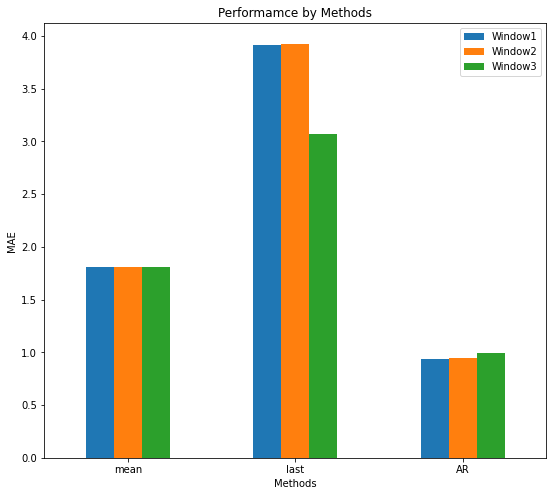

<Figure size 432x288 with 0 Axes>

In [14]:
# Plot your MSEs in a bar plot

ax = performance_df.plot(x="Method", y=['Window1', 'Window2', 'Window3'], kind= 'bar', 
                        title='Performamce by Methods',
                        xlabel = "Methods",
                        ylabel = "MAE",
                        figsize=(9, 8) )


plt.xticks(rotation=0)
plt.show()

plt.tight_layout()

In [15]:
# record end time

end = dt.now()
elapsed = end-start
print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:01:18
